In [1]:
# importing the libraries

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import date

plt.style.use('fivethirtyeight')

In [2]:
start_date = datetime.datetime(2010, 1, 1)
end_date = date.today()

df = yf.download("AAPL", start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496294,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507525,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404016,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392177,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434674,447610800


In [3]:
# Checking the number of rows and columns
df.shape

(3405, 6)

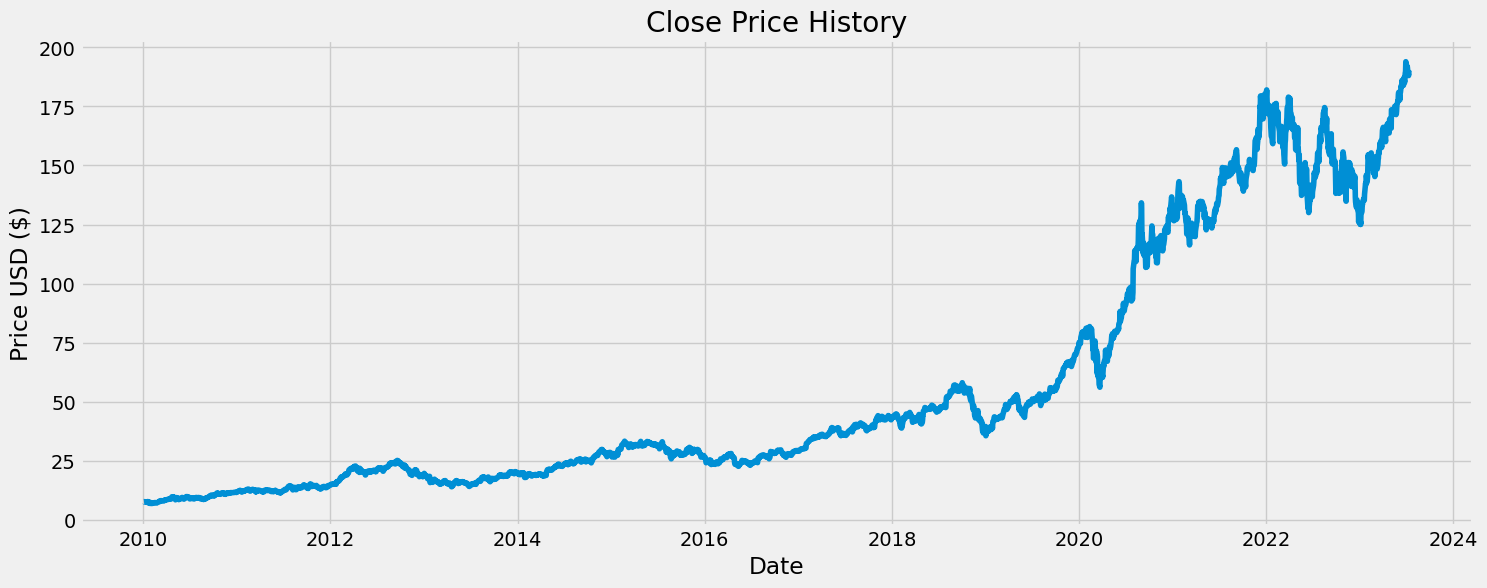

In [4]:
# Visualize the closing price history
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()

In [5]:
# Create a new dataframe with only 'Close' column
data = df.filter(['Close'])

# Converte the dataframe to np array
dataset = data.values

#Get the number of rows to train the models on. Using 80% of the data for training
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

2724

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00419155],
       [0.00426217],
       [0.0036113 ],
       ...,
       [0.97755346],
       [0.9816686 ],
       [0.98247031]])

In [7]:
# Create the training dataset
# Create the scaled the training dataset
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train, y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [8]:
# Converte the x_train, y_train to np array
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
# Checking the shape
x_train.shape

(2664, 60)

In [10]:
# Reshape the data into 3D for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(2664, 60, 1)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
model.fit(x_train, y_train, batch_size=10, epochs=4)

Epoch 1/4
267/267 [==============================] - 11s 27ms/step - loss: 4.6690e-04
Epoch 2/4
267/267 [==============================] - 7s 27ms/step - loss: 1.3982e-04
Epoch 3/4
267/267 [==============================] - 8s 29ms/step - loss: 1.3802e-04
Epoch 4/4
267/267 [==============================] - 8s 29ms/step - loss: 9.3661e-05


In [22]:
# Create the testing dataset
test_data = scaled_data[training_data_len - 60: , :]

# Create the datasets x_test, y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])
    
# Converte the data to a np array
x_test = np.array(x_test)

In [23]:
# Reshape the data into 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(681, 60, 1)

In [24]:
# Models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 0s 13ms/step


In [25]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

4.091965987643832

C:\Users\nawid\AppData\Local\Temp\ipykernel_28872\2153131758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


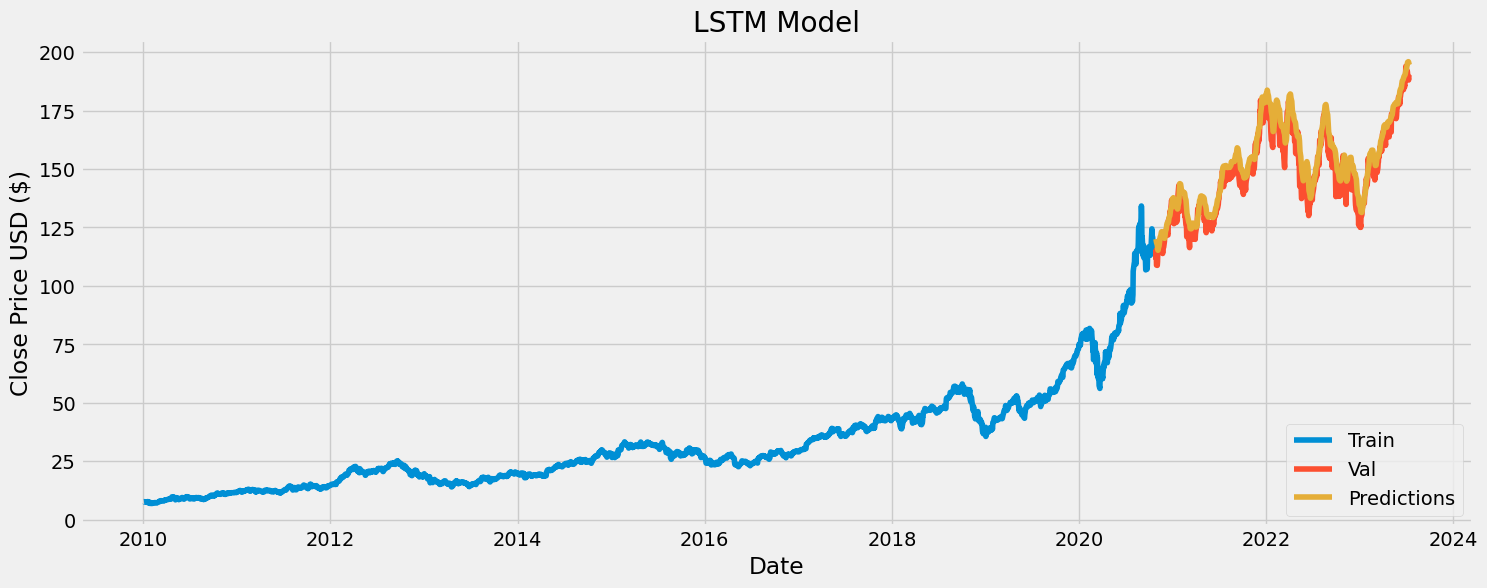

In [26]:
# Plot the data
train = data[ :training_data_len]
valid = data[training_data_len: ]
valid['predictions'] = predictions

#Visualize the model
plt.figure(figsize=(16, 6))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
# Show the valid and predicted prices
valid

,Close,predictions
Date,,
2020-10-28,111.199997,120.013283
2020-10-29,115.320000,119.107750
2020-10-30,108.860001,118.586197
2020-11-02,108.769997,117.540855
2020-11-03,110.440002,116.350220
...,...,...
2023-07-10,188.610001,195.943130
2023-07-11,188.080002,195.703186
2023-07-12,189.770004,195.157440


In [28]:
# Get the quote
apple_quote = yf.download("AAPL", start='2012-01-01', end='2019-12-17')

# Create a new dataframe
new_df = apple_quote.filter(['Close'])

# Get the last 60 day closing price and convert it to an array
last_60 = new_df[-60: ].values

#Scale the data
last_60_scaled = scaler.transform(last_60)

#Create a empty list
X_test = []

# Append the past 60 days
X_test.append(last_60_scaled)

# Converte the X_test dataset to a np array
X_test = np.array(X_test)

# Reshape the data to 3D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo scaling
pred_price = scaler.inverse_transform(pred_price)
print("Prediction Price 2019-12-18:", pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 28ms/step
Prediction Price 2019-12-18: [[69.03458]]


In [29]:
# Get the quote
apple_quote2 = yf.download("AAPL", start='2019-12-18', end='2019-12-19')
print("Actual Price 2019-12-18:", apple_quote2['Close'])

[*********************100%***********************]  1 of 1 completed
Actual Price 2019-12-18: Date
2019-12-18    69.934998
Name: Close, dtype: float64
